# 3. Preparación de los datos y tarea de regresión

## 3.1 Preparación de los datos

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

# Scikit-learn: preparación de los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

import re
import unicodedata

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve


In [2]:
df = load_and_info('data/df_investig_INR.csv')

columnas_a_eliminar = ['Unnamed: 0']

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=columnas_a_eliminar)


,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
2,CALCI,float64,0,53,"[7.52, 8.54, 2.21, 8.96, 9.12]"
3,HEMOGLOBINA,float64,0,93,"[10.3, 12.24, 8.7, 13.3, 14.0]"
4,VCM,float64,0,105,"[95.7, 103.26, 86.4, 80.6, 95.5]"
5,HEMATOCRIT,float64,0,108,"[31.8, 36.65, 43.2, 40.25, 41.93]"
6,PLAQUETES,float64,0,101,"[192.0, 177.36, 220.0, 200.0, 168.33]"
7,DIAGNOSTIC_ASSOCIAT,object,0,20,"[FA_NE, Flutter_NE, Valv_Aort_NReum_NE, EP_Oth..."
8,IMC,float64,0,106,"[27.33, 19.751666666666665, 27.425, 24.94, 34.13]"
9,HB_GLICOSILADA_A1C,float64,0,21,"[6.22, 8.0, 6.2, 6.3, 6.5]"



El juego de datos contiene 21 variables y 133 observaciones, de las cuales 0 son duplicadas.


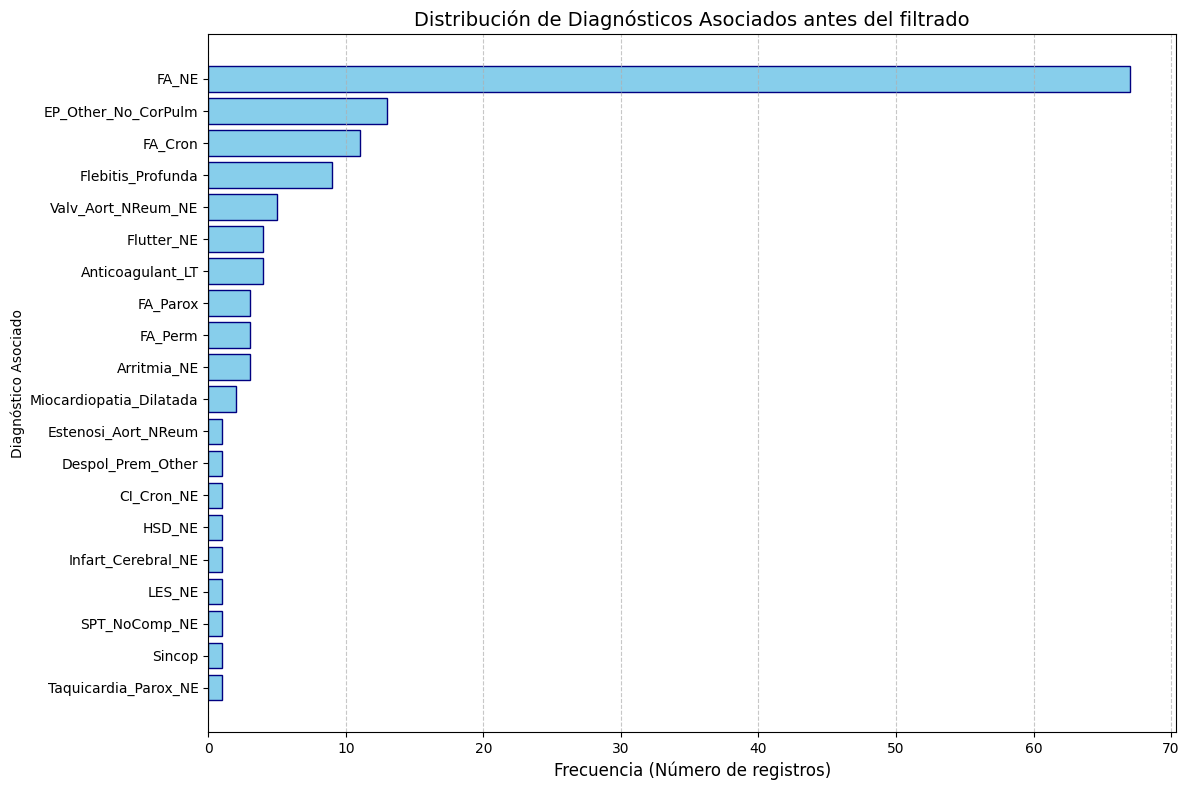

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparación de los datos de ejemplo (basado en tu descripción)
# Suponiendo que 'df' es tu DataFrame original
# Creamos variables dummies para la columna 'DIAGNÒSTIC_ASSOCIAT'
df_X_train_cat = pd.get_dummies(df['DIAGNOSTIC_ASSOCIAT'])
categorical_update = df_X_train_cat.columns.tolist()

# 2. Cálculo de frecuencias (tu lógica original)
freq_analysis = pd.DataFrame({
    'Variable': categorical_update,
    'Frecuencia': [df_X_train_cat[col].sum() for col in df_X_train_cat],
    'Porcentaje': [(df_X_train_cat[col].sum() / len(df_X_train_cat)) * 100 for col in categorical_update]
}).sort_values('Frecuencia', ascending=False)

# 3. Visualización de frecuencias
plt.figure(figsize=(12, 8))
plt.barh(freq_analysis['Variable'], freq_analysis['Frecuencia'], color='skyblue', edgecolor='navy')
plt.xlabel('Frecuencia (Número de registros)', fontsize=12)
plt.ylabel('Diagnóstico Asociado', fontsize=10)
plt.title('Distribución de Diagnósticos Asociados antes del filtrado', fontsize=14)
plt.gca().invert_yaxis()  # Invertir para que la más frecuente esté arriba
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df = df[df['DIAGNOSTIC_ASSOCIAT'].isin(['FA_NE', 'EP_Other_No_CorPulm','FA_Cron', 'Flebitis_Profunda'])].copy()

### División en las muestras de entrenamiento, validación, calibración y prueba

In [4]:
target_column = 'INR' 
X = df.drop(columns=[target_column])
y = df[target_column]

# X_train_full: 70% para Entrenamiento y Validación.
# X_test_full: 30% que contiene el Calibración y Prueba (el nuevo set completo de "test").
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.30, random_state=23)

# Paso 2: Dividir el 70% de entrenamiento (X_train_full) -> Entrenamiento (55%) y Validación (15%).
# El set de validación es 15% / 70% ≈ 0.21428 del conjunto X_train_full.
TEST_SIZE_VAL = 0.15 / 0.70

X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=TEST_SIZE_VAL, random_state=23)

# Dividir el 30% restante de test (X_test_full) -> Calibración (15%) y Prueba (15%).
# Mismo tamaño, por lo que el test_size es 0.5 (la mitad).

# Nota: La convención original era test=20% y cal=80% del 25%, ahora son ambos 50% del 30%.
X_test, X_calibration, y_test, y_calibration = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=23)

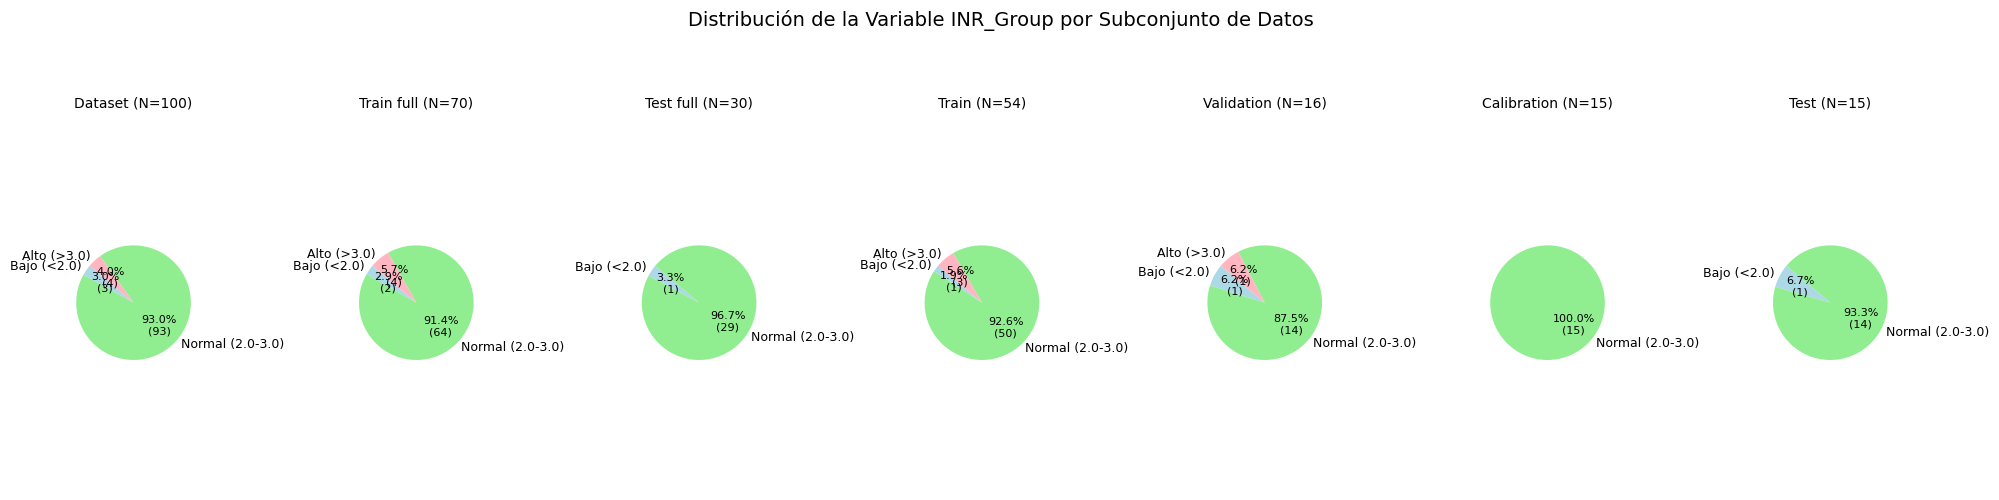

In [5]:
datasets = [df['INR'], y_train_full, y_test_full, y_train, y_validate, y_calibration, y_test]
distribution_INRGrout_Train(datasets)

### Codificación de las variables categóricas

In [6]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Usar handle_unknown
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")
ohe.fit(X_train) # Ajustamos solo en Entrenamiento

X_train_processed = ohe.transform(X_train)
X_val_processed = ohe.transform(X_validate)
X_test_processed = ohe.transform(X_test)
X_cal_processed = ohe.transform(X_calibration)

In [7]:
# Filtramos las columnas que han sido codificadas, esto es, contienen _ en el nombre
encoded_cols = [col for col in X_train_processed.columns if "_" in col]

display(X_train_processed[encoded_cols])

,DIAGNOSTIC_ASSOCIAT_EP_Other_No_CorPulm,DIAGNOSTIC_ASSOCIAT_FA_Cron,DIAGNOSTIC_ASSOCIAT_FA_NE,DIAGNOSTIC_ASSOCIAT_Flebitis_Profunda,HB_GLICOSILADA_A1C,CRIBRATGE_ALIMENTACIO,VALORACIO_AUDIT_C,NT_PROBNP,CREATINA_KINASA_CK,FREQ_CARDIACA
61,0.0,0.0,1.0,0.0,6.22,1.00,0.00,1660.5,63.10,70.666667
31,0.0,0.0,1.0,0.0,6.22,1.44,0.21,1660.5,63.10,80.000000
100,0.0,0.0,1.0,0.0,6.22,1.44,0.00,1660.5,63.10,73.833333
131,0.0,0.0,1.0,0.0,6.22,1.44,0.21,1660.5,63.10,66.500000
86,0.0,0.0,1.0,0.0,7.70,1.44,0.00,1660.5,63.10,106.500000
77,0.0,0.0,1.0,0.0,4.90,1.00,0.21,3954.0,63.10,59.750000
60,0.0,0.0,1.0,0.0,6.22,2.00,0.21,1660.5,63.10,58.000000
1,0.0,0.0,1.0,0.0,8.00,1.44,0.21,1660.5,63.10,73.857143
48,0.0,1.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.10,71.670000
50,0.0,0.0,1.0,0.0,6.22,1.44,0.21,1660.5,63.10,75.200000


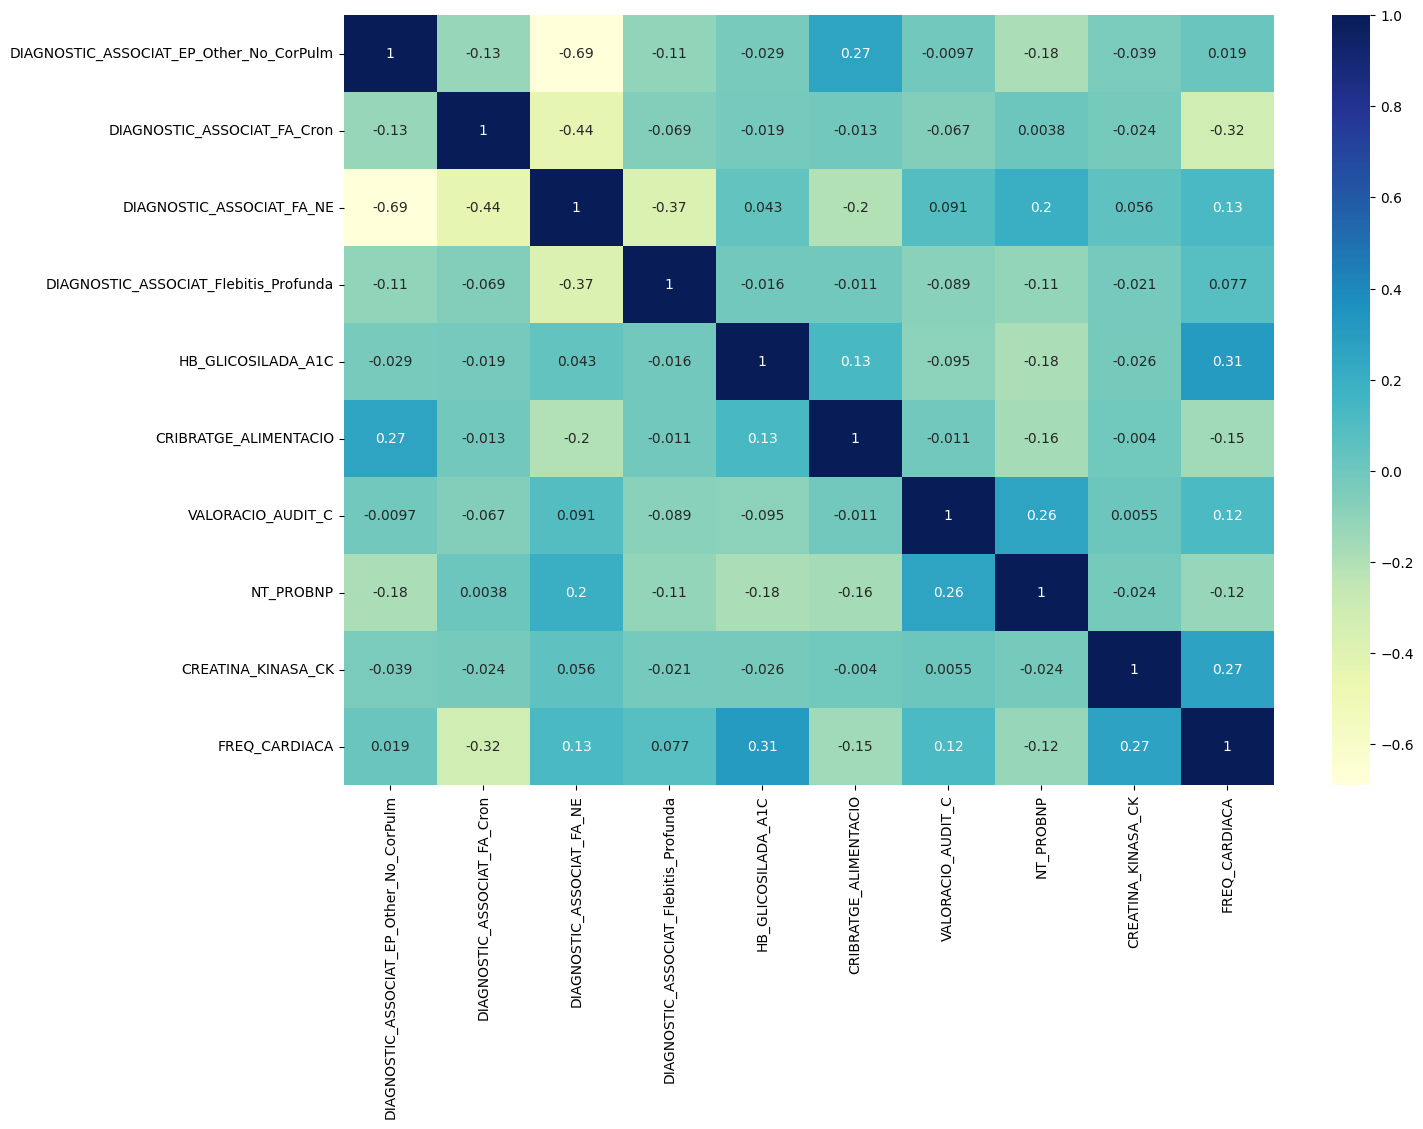

In [8]:
# Análisis de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_processed[encoded_cols].corr(), annot=True, cmap="YlGnBu")
plt.show()

Excluímos la información redundante eliminando una de las columnas:

### Imputación de valores ausentes

In [9]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('INR').tolist()

In [10]:
total_ausentes = X_train_full.isnull().sum().sum()
print(f"\nTotal de valores ausentes en todo el set de entrenamiento: {total_ausentes}")


Total de valores ausentes en todo el set de entrenamiento: 0


### Escalado por estandarización

Escalamos ahora las variables numéricas, de modo que se pueda comparar la magnitud de cada característica. Aplicaremos estandarización con StandardScaler(), cuyo método fit() calcula la media y la desviación estándar del conjunto de entrenamiento y transform() se encarga de substraer la primera y dividir por la segunda a cada muestra. Se consigue así que para cada variable la media sea cero y la varianza uno. Este proceso también se acostumbra a llamar normalización, aunque el término puede referirse únicamente a una transformación diferente, como es en la forma de la distribución en vez de en el rango de valores.

In [11]:
# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")
norm.fit(X_train_processed) # Ajustamos solo en Entrenamiento procesado

X_train_scaled = norm.transform(X_train_processed)
X_val_scaled = norm.transform(X_val_processed) # Transformamos Validación

X_test_scaled = norm.transform(X_test_processed)
X_cal_scaled = norm.transform(X_cal_processed)


# 4. Entrenamiento de los modelos

### Regression lineal

In [12]:
from sklearn.linear_model import LinearRegression

# 1. Inicializar el modelo
lr_model = LinearRegression()

# 2. Ajustar el modelo en el set de entrenamiento
lr_model.fit(X_train_scaled, y_train)

# 1. Realizar predicciones en el conjunto de prueba
lr_pred = lr_model.predict(X_test_scaled)

evaluate_model(y_test, lr_pred,'Regresión Lineal')

# Los nombres finales de las características son las columnas de X_train_scaled
final_feature_names = X_train_scaled.columns.tolist()

# Extraemos los coeficientes del modelo de Regresión Lineal
coefficients = lr_model.coef_

# Verificamos que el número de coeficientes coincida con el número de características
if len(final_feature_names) == len(coefficients):
    # Creamos un DataFrame para la interpretación
    lr_interpretation = pd.DataFrame({
        'Feature': final_feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    print("\n--- Coeficientes de Regresión Lineal (Baseline) ---")
    display(lr_interpretation)
else:
    print("Error: El número de coeficientes no coincide con el número de características.")
    print(f"Features: {len(final_feature_names)}, Coeficientes: {len(coefficients)}")

# Asegúrate de importar Pandas si aún no lo has hecho
import pandas as pd

--- Evaluación: Regresión Lineal ---
R² (Coeficiente de Determinación): -1.2028
RMSE (Error Cuadrático Medio): 0.3922
MAE (Error Absoluto Medio): 0.3367

--- Coeficientes de Regresión Lineal (Baseline) ---


,Feature,Coefficient
12,VALORACIO_AUDIT_C,0.220169
1,HEMOGLOBINA,0.099636
15,FREQ_CARDIACA,0.086955
7,PES,0.086931
18,DIAGNOSTIC_ASSOCIAT_EP_Other_No_CorPulm,0.080031
19,DIAGNOSTIC_ASSOCIAT_FA_Cron,0.046441
3,HEMATOCRIT,0.040812
9,MAGNESI,0.026056
8,CRIBRATGE_ALIMENTACIO,0.013061
11,CBPAAT,0.000522


### Arboles de decision

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Inicializar y ajustar el modelo (limitamos la profundidad para mantener la interpretabilidad)
dt_model = DecisionTreeRegressor(
    max_depth=7,            # Aumentar la profundidad a 7 (un buen compromiso)
    min_samples_leaf=5,     # Añadir una restricción de hoja para evitar sobreajuste extremo
    random_state=23
)

#evaluate_model(y_test, dt_pred,'Arboles de decisión')


### Random Forest Regressor

In [14]:
# Espacio de búsqueda para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [0.5, 0.7, 1.0]
}

best_rf = bestHiperparamethers_randomizedSearchCV(param_grid_rf,RandomForestRegressor(random_state=23),X_train_scaled, y_train)


Iniciando ajuste de RandomForestRegressor(random_state=23)...
Mejores parámetros RF: {'n_estimators': 100, 'min_samples_leaf': 20, 'max_features': 0.7, 'max_depth': 10}


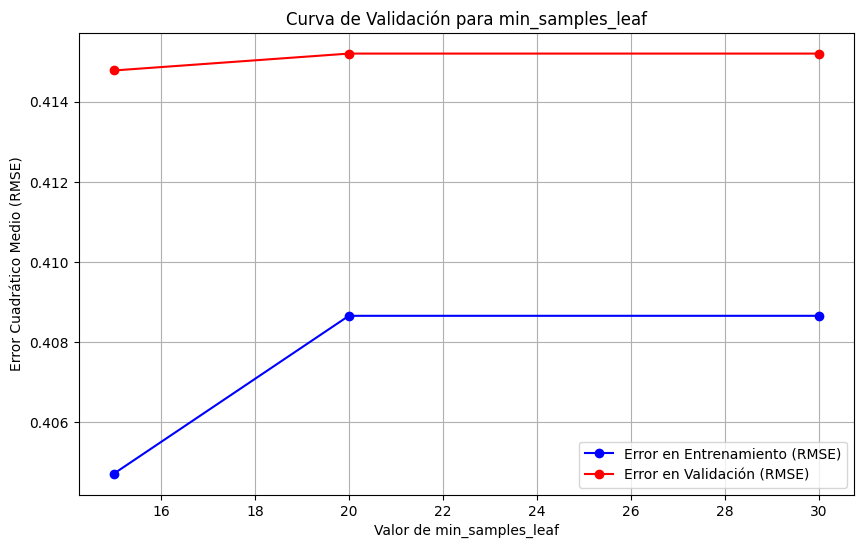

In [15]:
param_range_depth = [15, 20, 30]

plot_validation_curve_boosting(best_rf, X_train_scaled, y_train,"min_samples_leaf",param_range_depth)

Analicemos los puntos clave para tu justificación:

Error de Entrenamiento (Línea Azul):
El error (RMSE) en el conjunto de entrenamiento cae drásticamente a medida que la profundidad máxima (max_depth) aumenta.A partir de max_depth $\approx 10$, el error de entrenamiento se estabiliza en un valor extremadamente bajo (alrededor de $0.095$).Indicación: El modelo está memorizando perfectamente el conjunto de entrenamiento.

Error de Validación (Línea Roja):

El error (RMSE) en el conjunto de validación se estanca rápidamente.El error en validación deja de mejorar alrededor de max_depth $\approx 7$ o 8 y se mantiene constante en $\approx 0.28$.Indicación: A partir de $\text{max\_depth} = 8$, aumentar la complejidad del modelo (hacerlo más profundo) no aporta ningún valor predictivo en datos nuevos.Brecha (Gap) del Sobreajuste:La brecha vertical entre las líneas azul y roja es enorme a partir de max_depth $\approx 10$. El modelo cree que tiene un error de $0.095$, pero el error real en datos no vistos es de $0.28$.Conclusión para el Informe (Página 19/20)Esta gráfica explica por qué el Árbol de Decisión simple superó a los modelos complejos en tu primer análisis. El Árbol de Decisión simple no tenía la profundidad ni la capacidad de ensemble para sobreajustarse como tu Random Forest optimizado.

In [16]:
# Modelo de Random Forest con hiperparámetros corregidos
# Los demás parámetros se mantienen fijos del tuning:
# n_estimators=500, min_samples_leaf=1, max_features=1.0
rf_model_regularized = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    max_features=1.0,
    max_depth=None,      
    random_state=23,
    n_jobs=-1
)

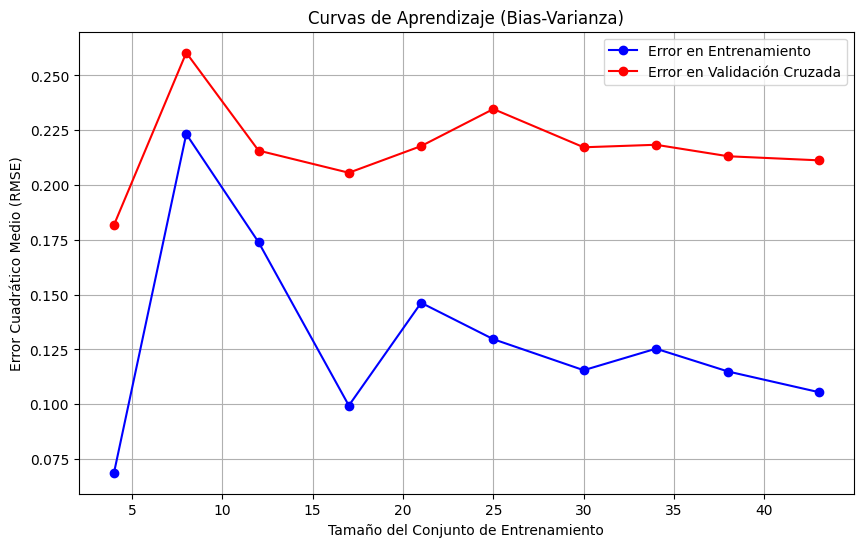

In [17]:
plot_learning_curve(rf_model_regularized, X_train_scaled, y_train)

 Curva de Aprendizaje, tras la regularización a $\text{max\_depth}=7$, confirma que el modelo ha alcanzado un estado de bajo sobreajuste (baja varianza), como se evidencia por la mínima brecha entre el error de entrenamiento y el error de validación. Además, la convergencia de las curvas en el extremo derecho indica que la cantidad de datos actual es suficiente para este nivel de complejidad, y agregar más muestras de entrenamiento no reduciría sustancialmente el Error Cuadrático Medio (RMSE) final del modelo.

### XGBRegressor


In [18]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

xgb_best = bestHiperparamethers_randomizedSearchCV(param_grid_xgb,XGBRegressor(random_state=23),X_train_scaled, y_train)

Iniciando ajuste de XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=23, ...)...
Mejores parámetros RF: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}


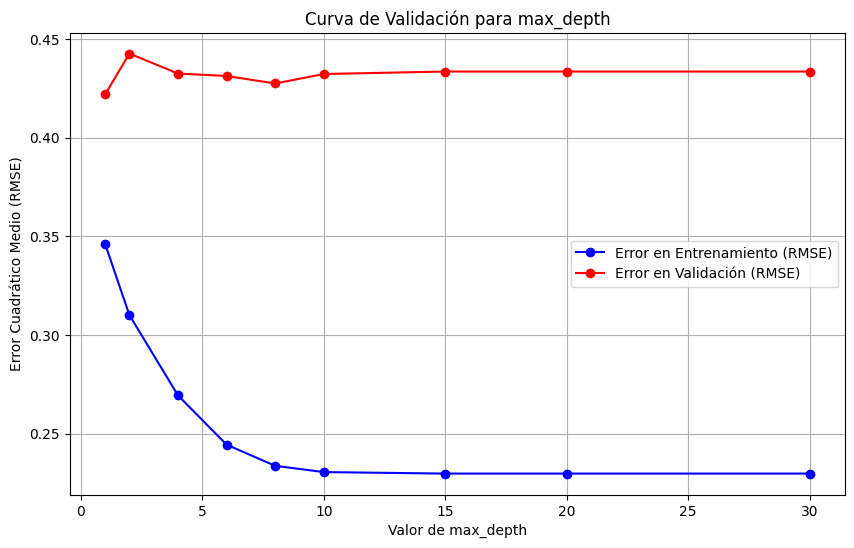

In [19]:
param_range_depth = [1, 2, 4, 6, 8, 10, 15, 20, 30]

plot_validation_curve_boosting(xgb_best, X_train_scaled, y_train,"max_depth",param_range_depth)

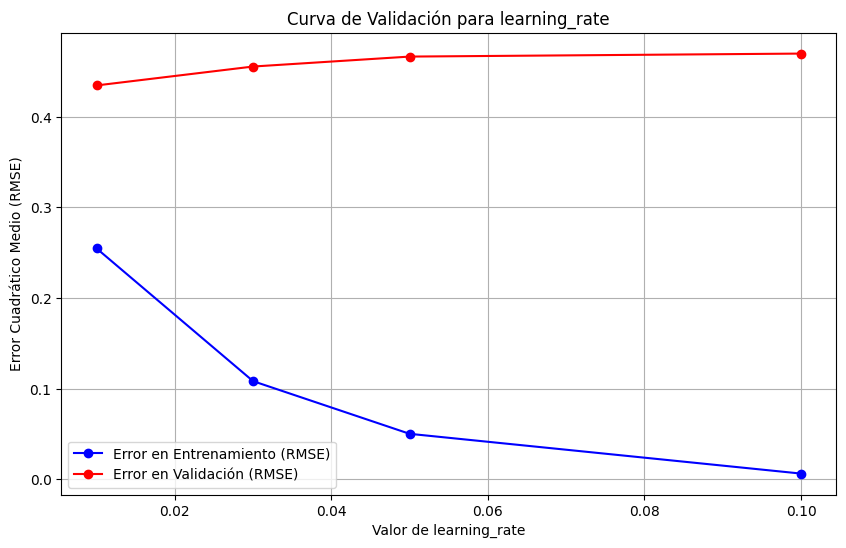

In [20]:
param_range_learning_rate = [0.01, 0.03, 0.05, 0.10]

plot_validation_curve_boosting(xgb_best, X_train_scaled, y_train,"learning_rate",param_range_learning_rate)

In [21]:
xgb_model_regularized = XGBRegressor(
    n_estimators=100,          
    learning_rate=0.05,      
    max_depth=3,            
    min_child_weight=20,         
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=23,
    n_jobs=-1
)

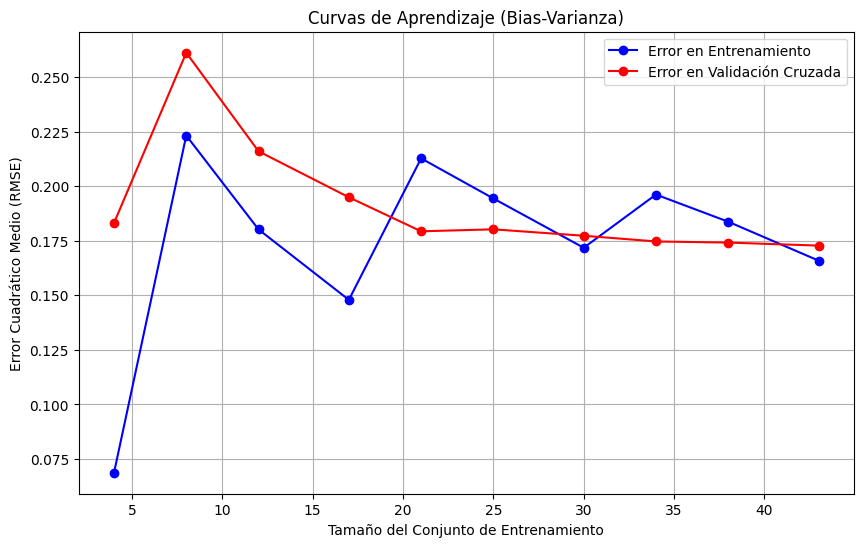

In [22]:
plot_learning_curve(xgb_model_regularized, X_train_scaled, y_train)

In [23]:
xgb_model_regularized.fit(X_train_scaled, y_train)

# 3. PREDECIR en el conjunto de PRUEBA
y_pred_rf_reg = xgb_model_regularized.predict(X_test_scaled)

# 4. CALCULAR el R2 score
r2_final = r2_score(y_test, y_pred_rf_reg)

print(f"\n--- Resultado del XBOOST Regularizado en el Conjunto de Prueba ---")
print(f"R² (Coeficiente de Determinación) Final: {r2_final:.4f}")


--- Resultado del XBOOST Regularizado en el Conjunto de Prueba ---
R² (Coeficiente de Determinación) Final: -0.1271


La curva de aprendizaje para el modelo XGBoost fuertemente regularizado (con $\text{learning\_rate}=0.005$) muestra que el modelo ha alcanzado su punto óptimo de rendimiento con la cantidad de datos disponibles. La estabilidad de la curva de Validación (roja) en el extremo derecho confirma que el modelo es robusto en la predicción y que no existe un beneficio marginal en aumentar el tamaño del conjunto de entrenamiento. La brecha residual entre las curvas (varianza) es el costo aceptado por la potencia del algoritmo y la complejidad de las relaciones no lineales en los datos."

### LGBMRegressor

In [24]:
from lightgbm import LGBMRegressor
from scipy.stats import uniform, randint
# Espacio de búsqueda para CatBoostRegressor
param_dist_lgbm = {
    # Parámetros comunes de boosting
    'n_estimators': randint(low=500, high=2000),      # Más alto que XGBoost para mejor rendimiento
    'learning_rate': uniform(loc=0.005, scale=0.1),   # Distribución uniforme entre 0.005 y 0.105
    
    # Parámetros clave de LightGBM (ajuste de la estructura del árbol)
    'num_leaves': randint(low=20, high=60),           # Número de hojas, crucial en LGBM (leaf-wise growth)
    'max_depth': randint(low=3, high=10),             # Profundidad máxima (se usa más para controlar la velocidad)
    'min_child_samples': randint(low=20, high=50),    # Regularización: Mínimo de muestras requeridas para formar una hoja
    
    # Parámetros de regularización
    'reg_alpha': uniform(loc=0, scale=0.01),          # Regularización L1
    'reg_lambda': uniform(loc=0, scale=0.01),         # Regularización L2
}

lgbm_base = LGBMRegressor(random_state=23, n_jobs=-1, metric='rmse', verbose=-1)
lgbm_best = bestHiperparamethers_randomizedSearchCV(param_dist_lgbm,lgbm_base,X_train_scaled, y_train)


Iniciando ajuste de LGBMRegressor(metric='rmse', n_jobs=-1, random_state=23, verbose=-1)...
Mejores parámetros RF: {'learning_rate': 0.08836812700492608, 'max_depth': 4, 'min_child_samples': 22, 'n_estimators': 1137, 'num_leaves': 55, 'reg_alpha': 0.004327296008898696, 'reg_lambda': 0.008760779531940953}


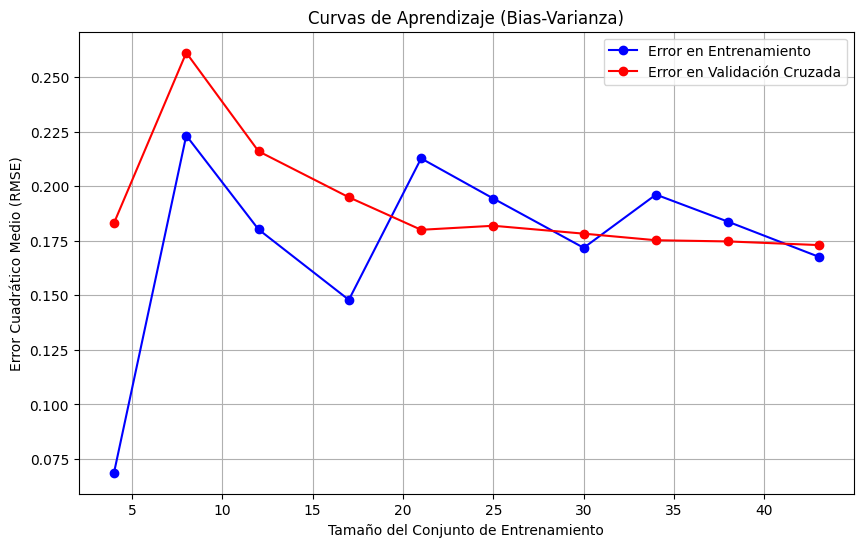

In [25]:
plot_learning_curve(lgbm_best, X_train_scaled, y_train)

## MEJOR MODELO

In [26]:
def evaluar_y_comparar_final(modelos, nombres, X_test, y_test):
    """
    Evalúa una lista de modelos en el conjunto de prueba (X_test, y_test)
    y retorna un DataFrame con las métricas de comparación.
    """
    
    # 1. Inicializar el diccionario para almacenar los resultados
    resultados = {}
    
    # 2. Iterar sobre cada modelo para predecir y evaluar
    for nombre, modelo in zip(nombres, modelos):
        
        # --- CORRECCIÓN CLAVE ---
        # El modelo DEBE generar predicciones antes de evaluar las métricas.
        y_pred = modelo.predict(X_test) 
        
        # Llamamos a tu función evaluate_model con los argumentos correctos:
        # (y_true=y_test, y_pred=y_pred, model_name=nombre)
        metricas = evaluate_model(y_test, y_pred, nombre)
        
        # Almacenar las métricas
        resultados[nombre] = metricas
        
    # 3. Retornar el resultado en un DataFrame de Pandas
    return pd.DataFrame(resultados).T

In [27]:
def plot_comparativa_final(df):
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    metrics = ['R2', 'RMSE', 'MAE']
    titles = ['R² (cerca de 1)', 'RMSE (cerca de 0)', 'MAE (cerca de 0)']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        bars = ax.bar(df.index, df[metric], color='skyblue')
        
        # Destacar al ganador (Máximo para R2, Mínimo para RMSE/MAE)
        if metric == 'R2':
            winner = df[metric].idxmax()
            criteria = 'max'
        else:
            winner = df[metric].idxmin()
            criteria = 'min'
            
        # Pintar la barra ganadora de color rojo para resaltarla
        winner_index = df.index.get_loc(winner)
        bars[winner_index].set_color('red')
        
        # Añadir etiquetas de valor
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, 
                    yval * (0.95 if yval < 0 else 1.05), # Ajuste para textos negativos
                    f'{yval:.3f}', ha='center', va='center', fontsize=9, color='black')

        ax.set_title(titles[i], fontsize=14)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--')
        
    plt.tight_layout()
    plt.show()

--- Evaluación: Linear regression ---
R² (Coeficiente de Determinación): -1.2028
RMSE (Error Cuadrático Medio): 0.3922
MAE (Error Absoluto Medio): 0.3367
--- Evaluación: Arboles de decision ---
R² (Coeficiente de Determinación): -1.0527
RMSE (Error Cuadrático Medio): 0.3786
MAE (Error Absoluto Medio): 0.3082
--- Evaluación: Random Forest ---
R² (Coeficiente de Determinación): 0.0508
RMSE (Error Cuadrático Medio): 0.2574
MAE (Error Absoluto Medio): 0.1751
--- Evaluación: XGBoost ---
R² (Coeficiente de Determinación): -0.1271
RMSE (Error Cuadrático Medio): 0.2805
MAE (Error Absoluto Medio): 0.1994
--- Evaluación: LGBMRegressor ---
R² (Coeficiente de Determinación): -0.4555
RMSE (Error Cuadrático Medio): 0.3188
MAE (Error Absoluto Medio): 0.2231


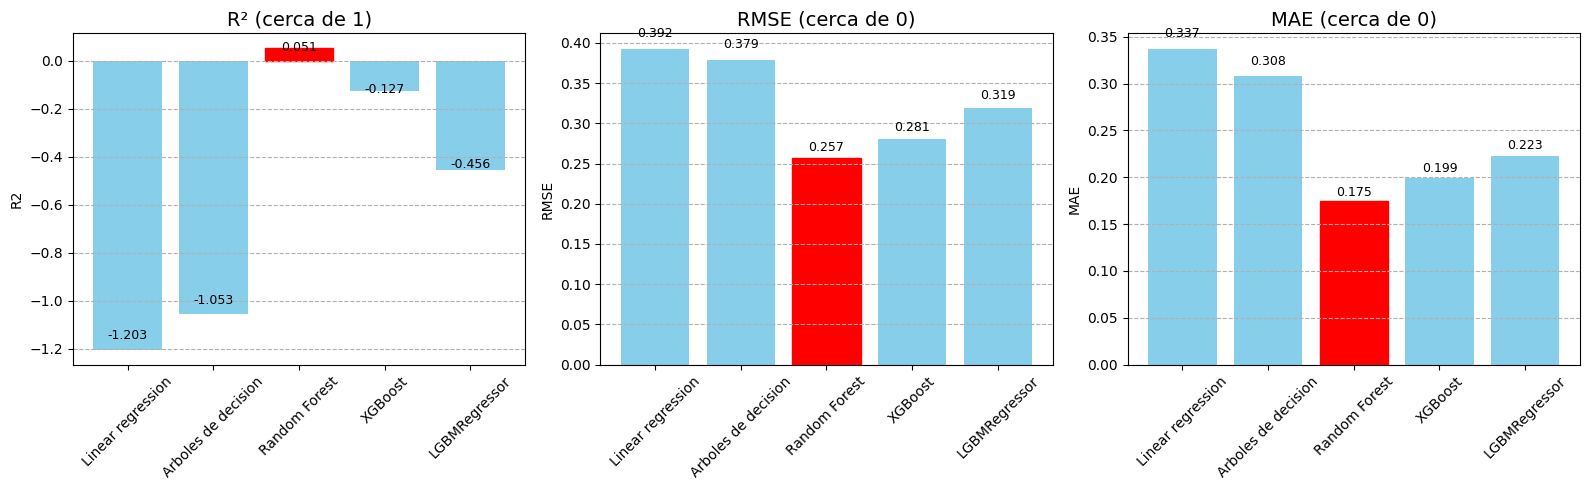

In [28]:
# 1. Crear las listas de modelos y nombres

rf_model_regularized.fit(X_train_scaled, y_train)
xgb_model_regularized.fit(X_train_scaled, y_train)
dt_model.fit(X_train_scaled, y_train)
#lgbm_best.fit(X_train_scaled, y_train)

modelos_finales = [lr_model, dt_model,rf_model_regularized, xgb_model_regularized,lgbm_best]
nombres_modelos = ['Linear regression','Arboles de decision','Random Forest', 'XGBoost','LGBMRegressor']

# 2. Ejecutar la función para obtener la tabla de comparación
# Usamos el set de PRUEBA (X_test, y_test) para la evaluación final imparcial.
tabla_final_comparativa = evaluar_y_comparar_final(
    modelos=modelos_finales,
    nombres=nombres_modelos,
    X_test=X_test_scaled,
    y_test=y_test
)



plot_comparativa_final(tabla_final_comparativa)

In [29]:
df.to_csv('data/df_investig_INR.csv')